# SMOTEN variant

if the dateset only consists of categorical features, so we are able to use SMOTEN variant. I just check it with GradientBoostingClassifier(), which works well on this data. If it produce better results than SMOTE, downsampling, it worth to expand.  


## data

In [1]:
# loading necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('thl_recoded.csv')
data.head()

,kannabis,alcohol_use,nuuska,cigarette,e_cigarette,prob_country,prob_resident,risk_of_use,risk_of_try,cannabis_access,...,household_2.0,household_3.0,education_2.0,education_3.0,education_4.0,violence_treat_2.0,violence_treat_3.0,drug_punishment_2.0,drug_punishment_3.0,drug_punishment_4.0
0,0.0,3.0,1.0,1.0,1.0,3.0,2.0,24.0,13.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,1.0,1.0,1.0,3.0,2.0,23.0,17.0,3.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,5.0,1.0,2.0,1.0,4.0,3.0,24.0,18.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,7.0,2.0,2.0,1.0,3.0,2.0,22.0,12.0,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,5.0,1.0,1.0,1.0,3.0,2.0,24.0,16.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [3]:
 # Kannabis use
data['kannabis'].value_counts(normalize= True)

0.0    0.914525
1.0    0.085475
Name: kannabis, dtype: float64

In [4]:
from sklearn.model_selection import train_test_split

X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values


## Smoten

In [5]:
from collections import Counter
from imblearn.over_sampling import SMOTEN

sampler = SMOTEN(random_state=0)
X_res, y_res = sampler.fit_resample(X, y)
print(f"Class counts after resampling {Counter(y_res)}")


#split data train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res,
                                                    y_res,
                                                    test_size=0.3,
                                                    random_state = 10)


Class counts after resampling Counter({0.0: 2953, 1.0: 2953})


# RFECV - Gradient Boosting Classifier

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=GradientBoostingClassifier())
model = GradientBoostingClassifier()

In [7]:
pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=36851234)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9519125987041467

In [8]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=GradientBoostingClassifier())),
                ('Model', GradientBoostingClassifier())])

In [9]:
print('Optimal number of features : %d' % rfecv.n_features_)

Optimal number of features : 35


In [10]:
rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv.support_rfecv_df.head(15)

,Rank
alcohol_use,1
midsize_city_1,1
small_city_1,1
drug_punishment_3.0,1
drug_user_friend_1,1
drug_offer_1,1
alcohol_hp_1,1
gender_3,1
"age_bins_(34, 44]",1
"age_bins_(44, 54]",1


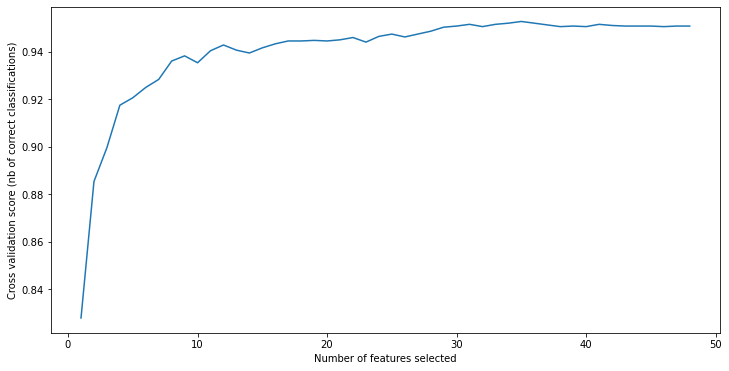

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Accuracy: 0.9543
Precision: 0.9546
Recall: 0.9543
F1 Score: 0.9543
Cohen Kappa Score: 0.9086
Matthews Corrcoef: 0.9089
roc_auc_score: 0.9545338689286734
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       881
         1.0       0.97      0.94      0.95       891

    accuracy                           0.95      1772
   macro avg       0.95      0.95      0.95      1772
weighted avg       0.95      0.95      0.95      1772

Confusion Matrix:
 [[852  52]
 [ 29 839]]


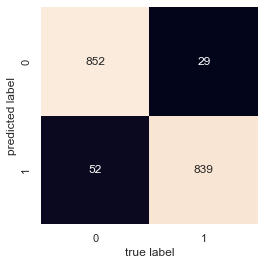

In [12]:
y_pred = pipeline.predict(X_test)
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

In [13]:
# list of features for further use
rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)

dt_columns = rfecv.support_rfecv_df [rfecv.support_rfecv_df ['Rank']==1].reset_index()
dt_columns = list(np.array(dt_columns['index']))
dt_columns 

['alcohol_use',
 'midsize_city_1',
 'small_city_1',
 'drug_punishment_3.0',
 'drug_user_friend_1',
 'drug_offer_1',
 'alcohol_hp_1',
 'gender_3',
 'age_bins_(34, 44]',
 'age_bins_(44, 54]',
 'age_bins_(54, 70]',
 'household_2.0',
 'household_3.0',
 'education_3.0',
 'violence_treat_3.0',
 'drug_punishment_2.0',
 'bigger_city_1',
 'helsinki_1',
 'rural_1',
 'other_drug_access',
 'nuuska',
 'cigarette',
 'e_cigarette',
 'prob_country',
 'risk_of_use',
 'risk_of_try',
 'cannabis_access',
 'in_relation_1',
 'drug_punishment_4.0',
 'non_medical_1',
 'has_child_1',
 'sport',
 'intoxicant_access',
 'doping_access',
 'current_health']

# Summary

The SMOTEN sampling technique also works well on this data. The sampling method could produces %94-95 accuracy level with around 20 features. I will finally apply hybrit method to compare its results with previous ones. 